In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.models

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [3]:
# Load object to artist ID's mapping.
import json
o2a = open('oid_to_artist_id.json')
object_to_artists = json.load(o2a)

In [4]:
from utils.data_utils import *

In [5]:
dtype = torch.cuda.FloatTensor 
num_artists = 25

In [6]:
# Define number of epochs, loss, optimizer
num_epochs = 1
criterion = nn.CrossEntropyLoss()

initial_lr = 1e-1

In [7]:
# Helper function to run a single epoch of a model.
def run_epoch(object_to_artists, model, optimizer):
#     Alexnet used this (incorrect) line
#     optimizer = torch.optim.Adam(model.classifier.parameters(), lr=initial_lr)
    train_losses = []
    val_losses = []
    train_path = 'data/train/'
    train_batch_gen = batch_generator(train_path)
    # Load each batch of training data.
    print_train_loss = 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(train_batch_gen)
            X, Y = get_array_from_batch(train_path, current_batch, object_to_artists)
            
            # Store next batch as Torch Variables.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y)).type(torch.cuda.LongTensor)
            
            # Forward pass.
            optimizer.zero_grad()
            batch_output = model(batch_input_var_pre)
            batch_loss = criterion(batch_output, batch_target_var)
            
            # Backpropagate.
            batch_loss.backward()
            optimizer.step()
            
            
            # Compute total loss.
            train_loss = batch_loss.data[0]
            print_train_loss += train_loss
            batch_counter += 1
            
            print_count = 50    
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                print('[%5d] train loss: %.3f' % (batch_counter, print_train_loss / print_count))
                train_losses.append(print_train_loss/print_count)
                print_train_loss = 0

    except StopIteration:
        pass
    
    # Load validation data.
    val_path = 'data/val/'
    val_batch_gen = batch_generator(val_path)
    print_val_loss = 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(val_batch_gen)
            X, Y = get_array_from_batch(val_path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Backpropagate.
            batch_output = model(batch_input_var_pre)
            batch_loss = criterion(batch_output, batch_target_var)
                      
            # Compute total loss.
            val_loss = batch_loss.data[0]
            print_val_loss += val_loss
#             val_losses.append(val_loss)
            batch_counter += 1

            print_count = 8
            if batch_counter % print_count == 0: # Append train loss every 10 batches.
                print('[%5d] val loss: %.3f' % (batch_counter, print_val_loss / print_count))
                val_losses.append(print_val_loss/print_count)
                print_val_loss = 0
                      
    except StopIteration:
        pass
    
    return train_losses, val_losses

In [8]:
def compute_accuracy(model, atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    num_predictions = 0
    num_correct_predictions = 0
    batch_size = 50
    batch_counter = 0
    train_batches = 100
    
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make predictions
            batch_output = model(batch_input_var_pre)
            
            predictions = torch.max(batch_output, 1)[1]
            
            # Check accuracy
            num_predictions += 50
            num_correct_predictions += torch.sum(torch.eq(predictions, batch_target_var)).data[0]
            
            batch_counter += 1
            if batch_counter == train_batches and atype == 'train':
                raise(StopIteration)
            
                      
    except StopIteration:
        accuracy = float(num_correct_predictions) / num_predictions
        print(atype + ' accuracy: ' + str(accuracy))
    

In [9]:
def graph_loss(train_loss, val_loss):
    plt.gca().cla()
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.legend()
    plt.draw()
    return 

In [10]:
def save_model(model, epoch_no, filepath_base):
    file_path = filepath_base + str(epoch_no)
    torch.save(model.state_dict(), file_path)

In [11]:
def load_model():
    pass

In [10]:
# AlexNet, pretrained
pigeonet = torchvision.models.alexnet(pretrained=True).cuda()
for param in pigeonet.parameters():
    param.requires_grad=False

pigeonet.classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256*6*6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, num_artists)
).cuda()

optimizer = torch.optim.Adam(pigeonet.classifier.parameters(), lr=initial_lr)

for i in range(10):
    print('Epoch: ' + str(i))
    run_epoch(object_to_artists, pigeonet, optimizer)
    compute_accuracy(pigeonet, 'train', object_to_artists)
    compute_accuracy(pigeonet, 'test', object_to_artists)

Epoch: 0
[   10] loss: 131366.813
[   20] loss: 1944.134
[   30] loss: 633.479
[   40] loss: 278.747
[   50] loss: 1233.444
[   60] loss: 162.775
[   70] loss: 125.864
[   80] loss: 95.174
[   90] loss: 395.183
[  100] loss: 13.670
[  110] loss: 11.427
[  120] loss: 19.958
[  130] loss: 12.396
[  140] loss: 4.050
[  150] loss: 44.805
[  160] loss: 3.109
[  170] loss: 10.215
[  180] loss: 4.456
[   10] loss: 35.794
[   20] loss: 136.502
train accuracy: 0.1192
test accuracy: 0.10736842105263159
Epoch: 1
[   10] loss: 258.095
[   20] loss: 27.981
[   30] loss: 310.028
[   40] loss: 635.592
[   50] loss: 67.513
[   60] loss: 31.900
[   70] loss: 31.097
[   80] loss: 15.976
[   90] loss: 993.406
[  100] loss: 522.237
[  110] loss: 743.631
[  120] loss: 262.716
[  130] loss: 270.198
[  140] loss: 348.583
[  150] loss: 105.848
[  160] loss: 468.707
[  170] loss: 1015.558
[  180] loss: 191.621
[   10] loss: 3.000
[   20] loss: 116.961
train accuracy: 0.1148
test accuracy: 0.11017543859649123
E

KeyboardInterrupt: 

In [ ]:
# Different existing architectures
# Inception on Trevor's recommendation
inception = torchvision.models.inception_v3(num_classes = num_artists)

In [11]:
# Small resnet, pretrained
resnet_small = torchvision.models.resnet18(pretrained=True).cuda()
for param in resnet_small.parameters():
    param.requires_grad=False

resnet_small.fc = nn.Linear(512, num_artists).cuda()

optimizer = torch.optim.Adam(resnet_small.fc.parameters(), lr=1e-3)

resnet_sm_train_losses = []
resnet_sm_val_losses = []
for i in range(10):
    print('Epoch: ' + str(i+1))
    curr_train_losses, curr_val_losses = run_epoch(object_to_artists, resnet_small, optimizer)
    resnet_sm_train_losses += curr_train_losses
    resnet_sm_val_losses += curr_val_losses
    compute_accuracy(resnet_small, 'train', object_to_artists)
    compute_accuracy(resnet_small, 'test', object_to_artists)


Epoch: 0
[   10] loss: 62.650
[   20] loss: 50.546
[   30] loss: 22.544
[   40] loss: 17.238
[   50] loss: 10.023
[   60] loss: 9.981
[   70] loss: 9.058
[   80] loss: 8.172
[   90] loss: 7.379
[  100] loss: 8.736
[  110] loss: 8.854
[  120] loss: 7.028
[  130] loss: 6.442
[  140] loss: 6.995
[  150] loss: 8.501
[  160] loss: 6.847
[  170] loss: 9.491
[  180] loss: 8.650
[   10] loss: 9.797
[   20] loss: 10.924
train accuracy: 0.4404
test accuracy: 0.4129824561403509
Epoch: 1
[   10] loss: 8.576
[   20] loss: 7.533
[   30] loss: 8.020
[   40] loss: 7.042
[   50] loss: 8.861
[   60] loss: 8.420
[   70] loss: 7.800
[   80] loss: 5.779
[   90] loss: 6.412
[  100] loss: 7.131
[  110] loss: 7.095
[  120] loss: 6.926
[  130] loss: 6.672
[  140] loss: 6.635
[  150] loss: 9.256
[  160] loss: 7.384
[  170] loss: 7.941
[  180] loss: 8.374
[   10] loss: 8.996
[   20] loss: 9.225
train accuracy: 0.5802
test accuracy: 0.523859649122807
Epoch: 2
[   10] loss: 6.966
[   20] loss: 7.585
[   30] loss: 

In [12]:
def generate_predictions(model, n_batches, atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    
    all_predictions = np.zeros((50 * n_batches))
    all_labels = np.zeros((50 * n_batches))
    batch_counter = 0

    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make predictions
            batch_output = model(batch_input_var_pre)
            
            predictions = torch.max(batch_output, 1)[1]
            predictions = predictions.view(predictions.size(0))
            start = batch_counter * 50
            all_predictions[start:start + 50] = predictions.data.cpu().numpy()
            all_labels[start:start + 50] = Y
            
            batch_counter += 1
            if batch_counter == n_batches:
                raise(StopIteration)
            
            
                      
    except StopIteration:
        pass
    
    return all_predictions, all_labels

In [13]:
import matplotlib.ticker as ticker

def plot_confusion_matrix(model, n_categories, n_batches, atype, object_to_artists):
    confusion = torch.zeros(n_categories, n_categories)
    
    predictions, labels = generate_predictions(model, n_batches, atype, object_to_artists)
    
    for i in range(predictions.shape[0]):
        prediction = predictions[i]
        label = labels[i]
        confusion[label][prediction] += 1
    
    
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax, cmap='jet')

    # Set up axes
    all_categories = ['Jan Luyken',
        'George Breitner',
        'Reinier Vinkeles',
        'Marius Bauer',
        'Isaac Israels',
        'Willem Witsen',
        'Daniel Chodowiecki',
        'Bernard Picart',
        'Rembrandt van Rijn',
        'Jacob Houbraken',
        'Antonio Tempesta',
        'Johannes Tavenraat',
        'Wenceslaus Hollar',
        'Simon Fokke',
        'Carel Cachet',
        'Jacob de Gheyn (II)',
        'Romeyn de Hooghe',
        'Meissener Manufaktur',
        'Jacques Callot',
        'Johann Sadeler (I)',
        'Jozef Israels',
        'Frans Hogenberg',
        'Crispijn van de Passe',
        'Jan van de Velde (II)',
        'Virgilius Solis (I)']
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


Epoch: 0
[   50] train loss: 2.640
[  100] train loss: 1.993
[  150] train loss: 1.715
[    8] val loss: 1.620
[   16] val loss: 1.628
[   24] val loss: 1.553
train accuracy: 0.5674
test accuracy: 0.5368421052631579
Epoch: 1
[   50] train loss: 1.494
[  100] train loss: 1.416
[  150] train loss: 1.404
[    8] val loss: 1.334
[   16] val loss: 1.350
[   24] val loss: 1.466
train accuracy: 0.621
test accuracy: 0.5757894736842105
Epoch: 2
[   50] train loss: 1.259
[  100] train loss: 1.270
[  150] train loss: 1.265
[    8] val loss: 1.411
[   16] val loss: 1.349
[   24] val loss: 1.341
train accuracy: 0.637
test accuracy: 0.5947368421052631
Epoch: 3
[   50] train loss: 1.147
[  100] train loss: 1.170
[  150] train loss: 1.176
[    8] val loss: 1.250
[   16] val loss: 1.329
[   24] val loss: 1.331
train accuracy: 0.652
test accuracy: 0.607719298245614
Epoch: 4
[   50] train loss: 1.088
[  100] train loss: 1.109
[  150] train loss: 1.123
[    8] val loss: 1.256
[   16] val loss: 1.325
[   2

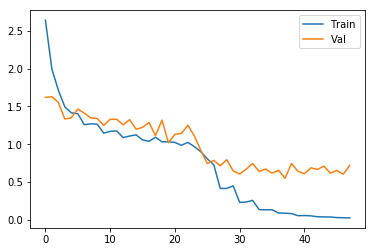

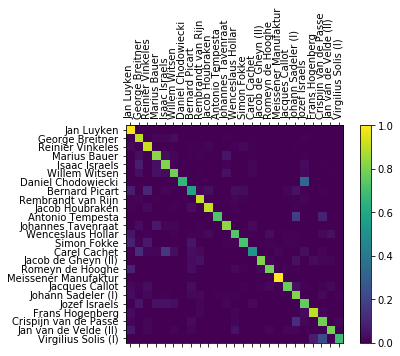

In [15]:
# Small resnet, pretrained, weights are being trained
resnet_small = torchvision.models.resnet18(pretrained=True).cuda()
for param in resnet_small.parameters():
    param.requires_grad = False

resnet_small.fc = nn.Linear(512, num_artists).cuda()
optimizer1 = torch.optim.Adam(resnet_small.fc.parameters(), lr=1e-3)
    
resnet_sm_train_losses_full = []
resnet_sm_val_losses_full = []
for i in range(8):
    print('Epoch: ' + str(i))
    curr_train_losses_full, curr_val_losses_full = run_epoch(object_to_artists, resnet_small, optimizer1)
    resnet_sm_train_losses_full += curr_train_losses_full
    resnet_sm_val_losses_full += curr_val_losses_full
    compute_accuracy(resnet_small, 'train', object_to_artists)
    compute_accuracy(resnet_small, 'test', object_to_artists)
    
# TRAIN ALL WEIGHTS!
for param in resnet_small.parameters():
    param.requires_grad = True

optimizer2 = torch.optim.Adam(resnet_small.parameters(), lr=4e-5) # smaller for all
for i in range(8):
    print('Epoch: ' + str(i))
    curr_train_losses_full, curr_val_losses_full = run_epoch(object_to_artists, resnet_small, optimizer2)
    resnet_sm_train_losses_full += curr_train_losses_full
    resnet_sm_val_losses_full += curr_val_losses_full
    compute_accuracy(resnet_small, 'train', object_to_artists)
    compute_accuracy(resnet_small, 'test', object_to_artists)

graph_loss(resnet_sm_train_losses_full, resnet_sm_val_losses_full)
plot_confusion_matrix(resnet_small, 25, 100, 'test', object_to_artists)

In [ ]:
# Medium resnet, transfer learning
resnet_medium = torchvision.models.resnet50(num_classes = num_artists).cuda()
resnet_small.fc = nn.Linear(512*4, num_artists).cuda()

for param in resnet_small.parameters():
    param.requires_grad = True
    
resnet_med_train_losses = []
resnet_med_val_losses = []
for i in range(20):
    print('Epoch: ' + str(i))
    curr_train_losses, curr_val_losses = run_epoch(object_to_artists, resnet_medium)
    resnet_med_train_losses += curr_train_losses
    resnet_med_val_losses += curr_val_losses
    compute_accuracy(resnet_medium, 'train', object_to_artists)
    compute_accuracy(resnet_medium, 'test', object_to_artists)

Epoch: 1
[   50] train loss: 2.383
[  100] train loss: 1.725
[  150] train loss: 1.527
[    8] val loss: 1.551
[   16] val loss: 1.459
[   24] val loss: 1.355
train accuracy: 0.6044
test accuracy: 0.576140350877193
Epoch: 2
[   50] train loss: 1.307
[  100] train loss: 1.271
[  150] train loss: 1.209
[    8] val loss: 1.334
[   16] val loss: 1.249
[   24] val loss: 1.258
train accuracy: 0.6394
test accuracy: 0.6066666666666667
Epoch: 3
[   50] train loss: 1.100
[  100] train loss: 1.096
[  150] train loss: 1.132
[    8] val loss: 1.264
[   16] val loss: 1.154
[   24] val loss: 1.152
train accuracy: 0.681
test accuracy: 0.6319298245614036
Epoch: 4
[   50] train loss: 1.014
[  100] train loss: 1.043
[  150] train loss: 1.024
[    8] val loss: 1.288
[   16] val loss: 1.165
[   24] val loss: 1.066
train accuracy: 0.6818
test accuracy: 0.6389473684210526
Epoch: 5
[   50] train loss: 0.982
[  100] train loss: 0.977
[  150] train loss: 1.004
[    8] val loss: 1.085
[   16] val loss: 1.185
[  

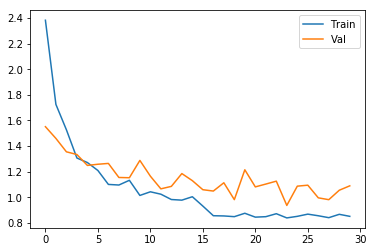

In [13]:
# Medium resnet, pretrained, weights are being trained
resnet_medium = torchvision.models.resnet50(pretrained=True).cuda()
for param in resnet_medium.parameters():
    param.requires_grad = False

resnet_medium.fc = nn.Linear(512*4, num_artists).cuda()
optimizer1 = torch.optim.Adam(resnet_medium.fc.parameters(), lr=1e-3)
    
resnet_med_train_losses_full = []
resnet_med_val_losses_full = []
for i in range(5):
    print('Epoch: ' + str(i+1))
    curr_train_losses_med, curr_val_losses_med = run_epoch(object_to_artists, resnet_medium, optimizer1)
    resnet_med_train_losses_full += curr_train_losses_med
    resnet_med_val_losses_full += curr_val_losses_med
    compute_accuracy(resnet_medium, 'train', object_to_artists)
    compute_accuracy(resnet_medium, 'test', object_to_artists)
    
# TRAIN ALL WEIGHTS!
for param in resnet_medium.parameters():
    param.requires_grad = True

optimizer2 = torch.optim.Adam(resnet_medium.fc.parameters(), lr=1e-5) # smaller for all
for i in range(5):
    print('Epoch: ' + str(i+1))
    curr_train_losses_full, curr_val_losses_full = run_epoch(object_to_artists, resnet_medium, optimizer2)
    resnet_med_train_losses_full += curr_train_losses_full
    resnet_med_val_losses_full += curr_val_losses_full
    compute_accuracy(resnet_medium, 'train', object_to_artists)
    compute_accuracy(resnet_medium, 'test', object_to_artists)

graph_loss(resnet_med_train_losses_full, resnet_med_val_losses_full)

In [ ]:
optimizer2 = torch.optim.Adam(resnet_medium.fc.parameters(), lr=5e-5) # smaller for all
for i in range(5):
    print('Epoch: ' + str(i+1))
    curr_train_losses_full, curr_val_losses_full = run_epoch(object_to_artists, resnet_medium, optimizer2)
    resnet_med_train_losses_full += curr_train_losses_full
    resnet_med_val_losses_full += curr_val_losses_full
    compute_accuracy(resnet_medium, 'train', object_to_artists)
    compute_accuracy(resnet_medium, 'test', object_to_artists)

graph_loss(resnet_med_train_losses_full, resnet_med_val_losses_full)

In [11]:
# VGG 16
vgg16_model = torchvision.models.vgg16(pretrained=True).cuda()
vgg16_model.classifier = nn.Sequential(
    nn.Linear(512*7*7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_artists)
).cuda()

for param in vgg16_model.parameters():
    param.requires_grad = True
    
vgg16_train_losses = []
vgg16_val_losses = []

for i in range(5):
    print('Epoch: ' + str(i))
    curr_train_losses, curr_val_losses = run_epoch(object_to_artists, vgg16_model)
    vgg16_train_losses += curr_train_losses
    vgg16_val_losses += curr_val_losses
    compute_accuracy(vgg16_model, 'train', object_to_artists)
    compute_accuracy(vgg16_model, 'test', object_to_artists)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/debnil/.torch/models/vgg16-397923af.pth
98.2%

Epoch: 0


AttributeError: type object 'object' has no attribute '__getattr__'

In [ ]:
models = [pigeonet, inception, resnet_small, resnet_medium, resnet_large]

In [14]:
''' To Do Cell
1. write function to graph train and val losses over epochs
2. resnet small w full parameter training
3. resnet small w only classifier training
4. resnet medium w full paramter training
5. resnet medium w only classifier training
6. vgg16 w full parameter training
7. vgg16 w only classifier training
8. style embedding --> classifier
9. content embedding --> classifier
'''

' To Do Cell\n1. write function to graph train and val losses over epochs\n2. resnet small w full parameter training\n3. resnet small w only classifier training\n4. resnet medium w full paramter training\n5. resnet medium w only classifier training\n6. vgg16 w full parameter training\n7. vgg16 w only classifier training\n8. style embedding --> classifier\n9. content embedding --> classifier\n'